# Experiment 1.3.2
This is a copy of experiment 1.3.1. It is being repeated as I realized that I made a mistake by not holding the parameters of the model fixed (the parameters before the newly created last layer).

## Dataset 
First, we need to organise our orange-brown dataset in a way that Pytorch can consume it. We will be trying to train it to distinguish orange and brown colors.

Most of the work for this has been done by the nncolor.data module. Below we just test it out to make sure it's working. 

The dataset is supposed to use the data from experiment 1.1.1 to produce circles against a background. But we make the circles smaller and place them in 1 of 4x4=16 grid positions. This is done to force the model to learn the answer invariant of where it appears in the image.

In [1]:
import cv2
import numpy as np
from enum import Enum
import colorsys
import moviepy.editor as mpe
import moviepy
from typing import *
import random
import pandas as pd
import json
import torch
from icecream import ic
import nncolor as nc
import nncolor.data

In [2]:
import IPython
def imshow(img):
    img = img*255
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

In [3]:
def demo_data():
    FPS = 2
    #frames = [circle_img(p, (255, 255, 255), (50, 20, 20)) for p in range(NUM_POSITIONS)]
    #labels = ['WB-0']*len(frames)
    frames, labels = nc.data.create_samples(30)
    frames = [f*255 for f in frames]
    x_clip = mpe.ImageSequenceClip(frames, fps=2)
    y_clip = mpe.TextClip('WB-0', font='DejaVu-Sans')

    class FrameText(mpe.VideoClip):
        def __init__(self, text, fps):
            def make_frame(f):
               return mpe.TextClip(text[int(f)], font='DejaVu-Sans', color='white').get_frame(f)
            self.duration = 1.0 * len(text) / fps
            mpe.VideoClip.__init__(self, make_frame=make_frame, duration=self.duration)

    y_clip =   FrameText(labels, FPS)
    label_clip = mpe.CompositeVideoClip([mpe.ImageClip(np.zeros(nc.data.DEFAULT_IMG_SHAPE), duration=5), y_clip])
    comp_clip = mpe.clips_array([[y_clip],[x_clip]])
    return comp_clip
clip = demo_data() 
clip.ipython_display()

t:  20%|██        | 6/30 [00:00<00:00, 59.28it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


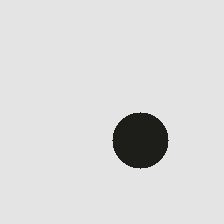

In [4]:
def test_dataset():
    train, test, val = nc.data.load_datasets()
    imshow(val[300]['image'])
test_dataset()

## Training
Let's fine tune a Resnet model.

In [5]:
# Copied from: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

import torchvision as tv
import torchvision.datasets
import torchvision.models
import torchvision.transforms
import torch.nn
import torch.optim
import time
import copy
import os

# Data augmentation and normalization for training
# Just normalization for validation
data_transform = tv.transforms.Compose([
        tv.transforms.ToTensor(),
        tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
train_ds, test_ds, val_ds = nncolor.data.load_datasets()
train_ds.transform = data_transform
val_ds.transform = data_transform
ds = {'train': train_ds, 'val': val_ds}
dataloaders = {x: torch.utils.data.DataLoader(ds[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(ds[x]) for x in ['train', 'val']}

device = (torch.device("cuda:0") if torch.cuda.is_available() else "cpu")

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            #for inputs, labels in dataloaders[phase]:
            for batch in dataloaders[phase]:
                inputs = batch['image'].to(device)
                labels = batch['label'].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Load & train
model_ft = tv.models.resnet18(pretrained=True)

## [begin] This is where experiment 1.3.2 differs:
for param in model_ft.parameters():
    param.requires_grad = False
## [end]
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = torch.nn.Linear(num_ftrs, 4)
model_ft = model_ft.to(device)
criterion = torch.nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
num_epochs = 20 
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/19
----------
train Loss: 0.7198 Acc: 0.7005
val Loss: 0.2836 Acc: 0.8828

Epoch 1/19
----------
train Loss: 0.6660 Acc: 0.7348
val Loss: 0.5242 Acc: 0.8021

Epoch 2/19
----------
train Loss: 0.6259 Acc: 0.7591
val Loss: 0.5345 Acc: 0.8438

Epoch 3/19
----------
train Loss: 0.6224 Acc: 0.7569
val Loss: 0.3835 Acc: 0.8151

Epoch 4/19
----------
train Loss: 0.5933 Acc: 0.7682
val Loss: 0.3465 Acc: 0.8672

Epoch 5/19
----------
train Loss: 0.6255 Acc: 0.7509
val Loss: 0.6320 Acc: 0.7656

Epoch 6/19
----------
train Loss: 0.6397 Acc: 0.7569
val Loss: 0.3213 Acc: 0.8594

Epoch 7/19
----------
train Loss: 0.5053 Acc: 0.8008
val Loss: 0.3831 Acc: 0.8932

Epoch 8/19
----------
train Loss: 0.4915 Acc: 0.8034
val Loss: 0.3003 Acc: 0.8776

Epoch 9/19
----------
train Loss: 0.5277 Acc: 0.7860
val Loss: 0.3716 Acc: 0.8490

Epoch 10/19
----------
train Loss: 0.5174 Acc: 0.7956
val Loss: 0.2807 Acc: 0.8802

Epoch 11/19
----------
train Loss: 0.5000 Acc: 0.8073
val Loss: 0.2436 Acc: 0.8672

Ep

## Results
After 5 epochs, all epochs (tried up to 20) have >80% validation accuracy. The 20th epoch had 87% accuracy. This is a little lower than the accuracy seen in 1.3.1, but it's still high enough to come to the same conclusion: there's enough information coming into the last layer for it to distinguish brown and orange. _What_ is this information?

## Next steps (copied from 1.3.1)
The results show us that there is enough info coming into the last layer to distinguish between the orange and brown dots on the 4x4 grid. 1.4 tries to probe this information by seeing how accuracy is affected by zeroing sets of inputs to the last layer.  

There are a few ways we can probe:
  1. randomly choose a set of activations to zero. How big to make the set?
  2. estimate the order of the activation importance, and start from the top or bottom.
  3. look at the layer before final pooling. We are interested in seeing if the network has a degree of resolution to its color.
  
For the first method, we need a way to aggregate the result of multiple trials in order to draw conclusions about particular activations. For the second method, we need a way to estimate the activation importance. 

The 3rd method is the most similar to this experiment, so let's do that first (experiment 1.4).


## Validation vs. training accuracy
Another observation is that validation accuracy is greater than training accuracy. This would be reasonable if training uses some dropout or similar technique; however, I'm not sure if it does or not. Worth investigating this to find possible configuration mistakes.